# Stage I

1) сгенерить waveform синуса,  с напр., 10k отсчетов (на один период) (1 Hz)

2) нарисовать его, нарисовать fft, и попробовать правильно подписать оси и деления шкал на них ;)

3) сымитировать оцифровку -- понизить чсило отсчетов например а) до 500, и до 25 — и повторить п.2, при этом увидеть какие искажения в спектре возникли

4) сымитировать "кривую" оцифровку -- при уменьшении частоты дескритезации брать отсчеты с разным смещением в лево и вправо,
(аналог физовых искажений, jitter), и снова посмотреть 2) на 5-10% периода

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, rfft
from scipy import signal
from typing import Tuple, List, TypeVar
import random
import math

%matplotlib inline

In [8]:
def sin_tick(sampling_rate: int, period: int = 1) -> Tuple[np.array, np.array]:
    x = np.linspace(0, 1 * int(period), sampling_rate, endpoint=True)
    y = np.sin(2 * np.pi * x)
    return x, y

def rand_sigh():
    return -1 if random.random() > 0.5 else 1.0

In [9]:
def sin_tick_rand_jitter(sampling_rate: int, periods_count: int, jitter_tick_max_percent: float = 0.0, jitter_magnitude_max_percent: float = 0.0) -> Tuple[np.array, np.array]:
    random.seed(1112220)
    x = []
    size = 0.
    jit_tick = (float(jitter_tick_max_percent) / 100.)
    jit_mag = (float(jitter_magnitude_max_percent) / 100.)
    lin_x = np.linspace(0, periods_count, sampling_rate, endpoint=True)
    for i, ix in enumerate(lin_x):
        if i in {0, sampling_rate}:
            x.append(float(ix))
            continue
        xf = float(ix)
        if size == 0.:
            size = abs(xf)
        xf = xf + size * jit_tick * rand_sigh()
        x.append(xf)
    random.seed(3312220)
    y = []
    for ix in x:
        yi = 1 * math.sin(2 * math.pi * ix)
        yi = yi + abs(yi) * jit_mag * rand_sigh()
        y.append(yi)
    assert jitter_tick_max_percent == 0. or jitter_magnitude_max_percent == 0.
    if jitter_tick_max_percent != 0.:
        return lin_x, np.array(y)
    return np.array(x), np.array(y)

# FFT

[scipy.fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html)

`fft(x, n)` - Return discrete Fourier transform of real or complex sequence.

`fftshift(x)` - Shift the zero-frequency component to the center of the spectrum.

In [15]:
# The power spectrum is calculated as the square of
# the absolute value of the discrete Fourier transform
# https://www.kite.com/python/answers/how-to-plot-a-power-spectrum-in-python

def mk_signal_by_spectrum_magnitude(signal_fft: np.array, sampling_rate: int):
    t = np.linspace(0, 1, sampling_rate)
    r = np.fft.irfft(signal_fft, sampling_rate)

    plt.figure(figsize=(30, 4))
    plt.plot(t, r)
    plt.xlim((0, max(t)))
    plt.grid()
    plt.show()

def spectrum_magnitude(signal: np.array, sampling_rate: int, *, plot: bool) -> None:
    signal_fft = np.fft.rfft(signal, len(signal))
    spectrum = np.square(np.abs(signal_fft))

    freq = np.linspace(0, sampling_rate/2, len(signal_fft))

    df = pd.DataFrame({"spectrum": spectrum, "freq": freq})

    max_freq = df.iloc[df['spectrum'].idxmax()]['freq'] or 0.

    if plot:
        plt.grid()
        plt.title(f'magnitude spectrum (max_freq={max_freq:0.3f})')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, spectrum)
    return spectrum, freq

def spectrum_phase(signal: np.array, sampling_rate: int, *, plot: bool) -> None:
    signal_fft = np.fft.rfft(signal, len(signal))
    freq = np.linspace(0, sampling_rate/2, len(signal_fft))
    phase_spectrum = np.angle(signal_fft)

    df = pd.DataFrame({"spectrum": np.square(np.abs(signal_fft)), "freq": freq})

    max_freq = df.iloc[df['spectrum'].idxmax()]['freq'] or 0.

    if plot:
        plt.grid()
        plt.title('phase spectrum')
        plt.xlabel("freq")
        plt.ylabel("level")
        plt.xlim([freq[0], min(max_freq * 10, freq[-1])])
        plt.plot(freq, phase_spectrum)
    return phase_spectrum, freq



sampling_rate=10000


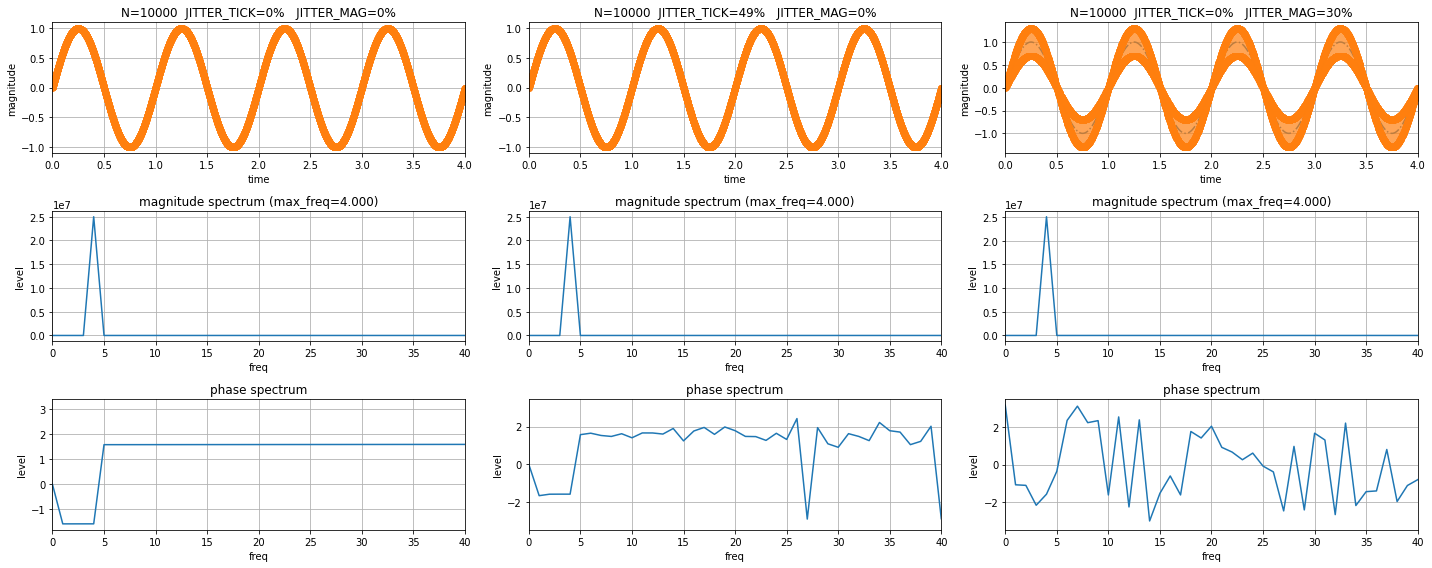



sampling_rate=5000


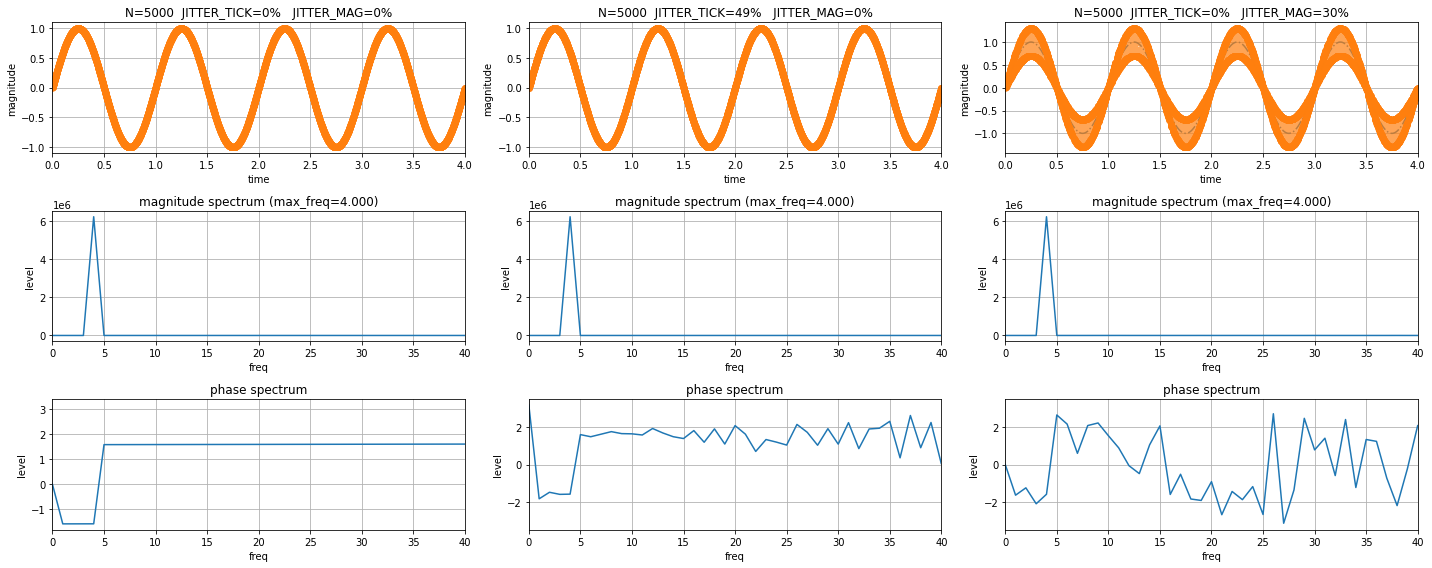



sampling_rate=500


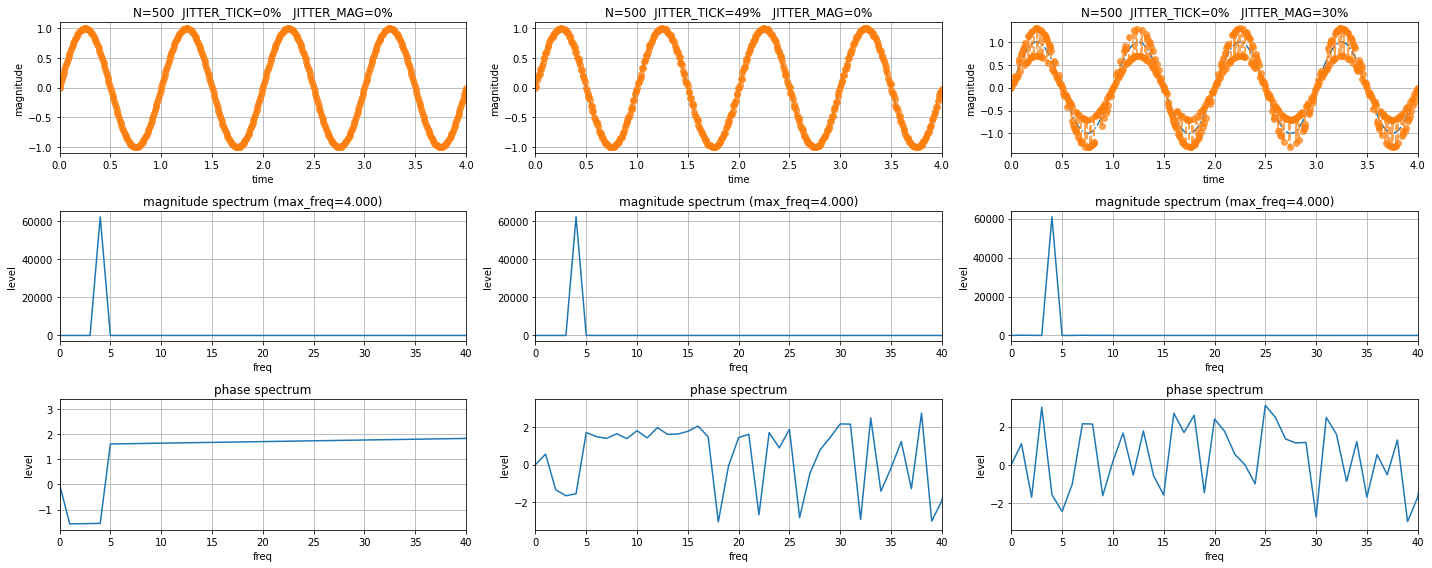



sampling_rate=100


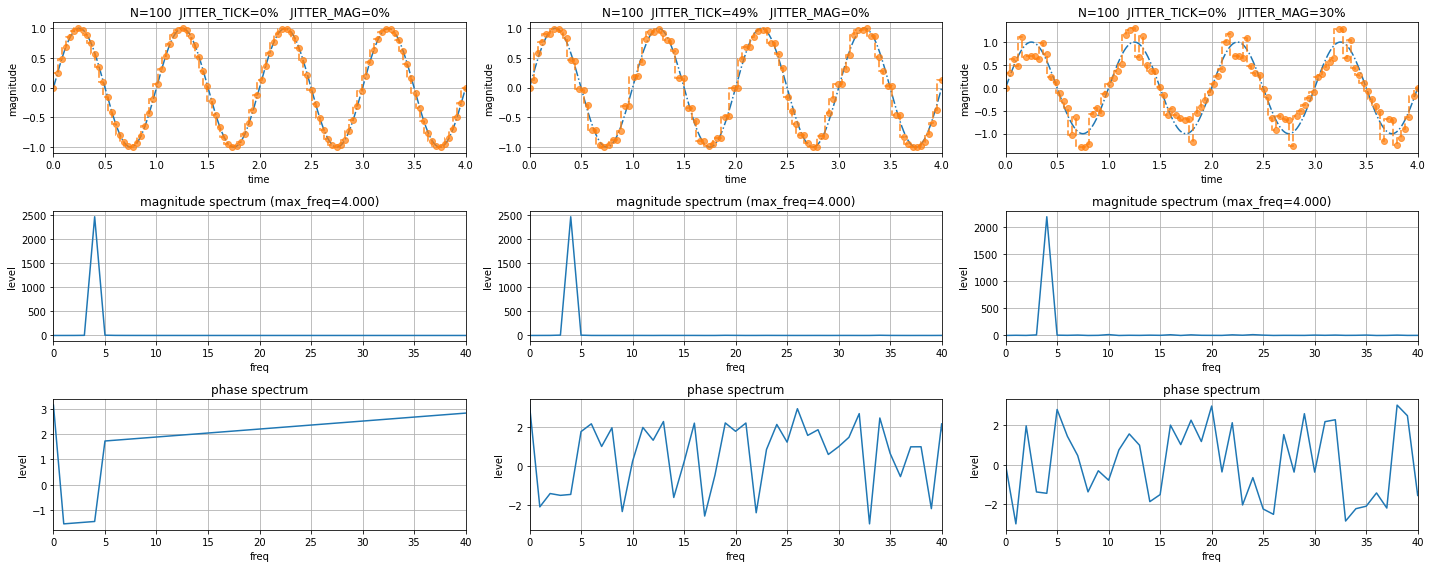



sampling_rate=25


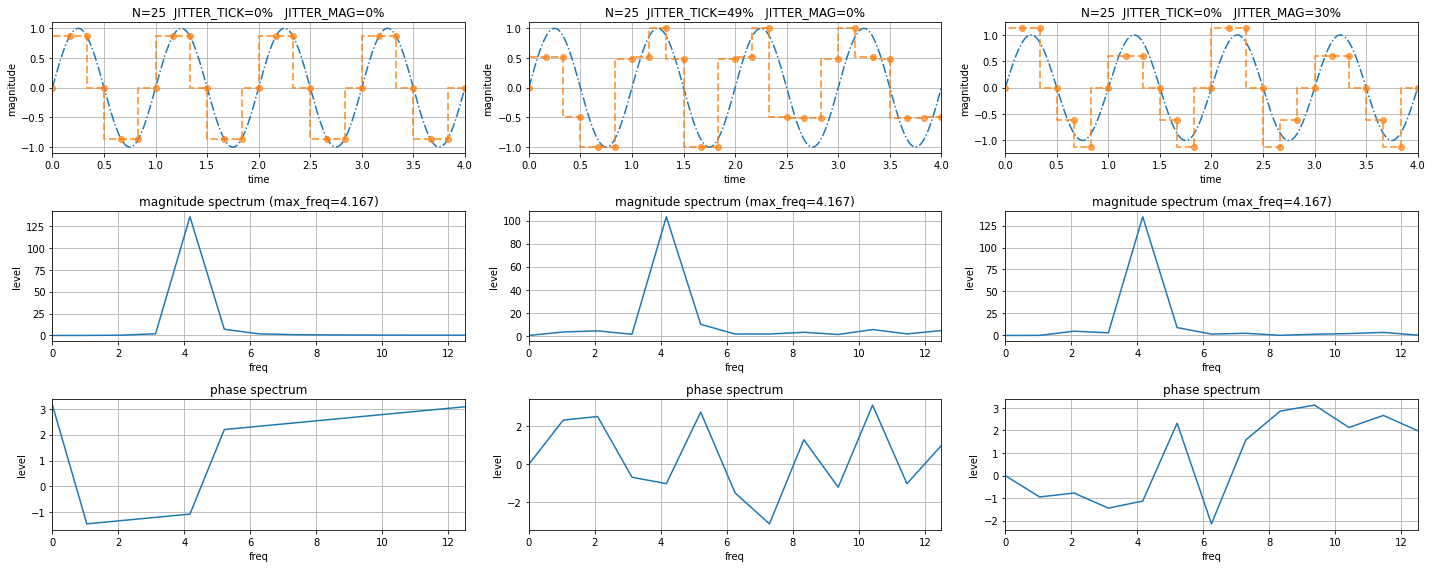



sampling_rate=10


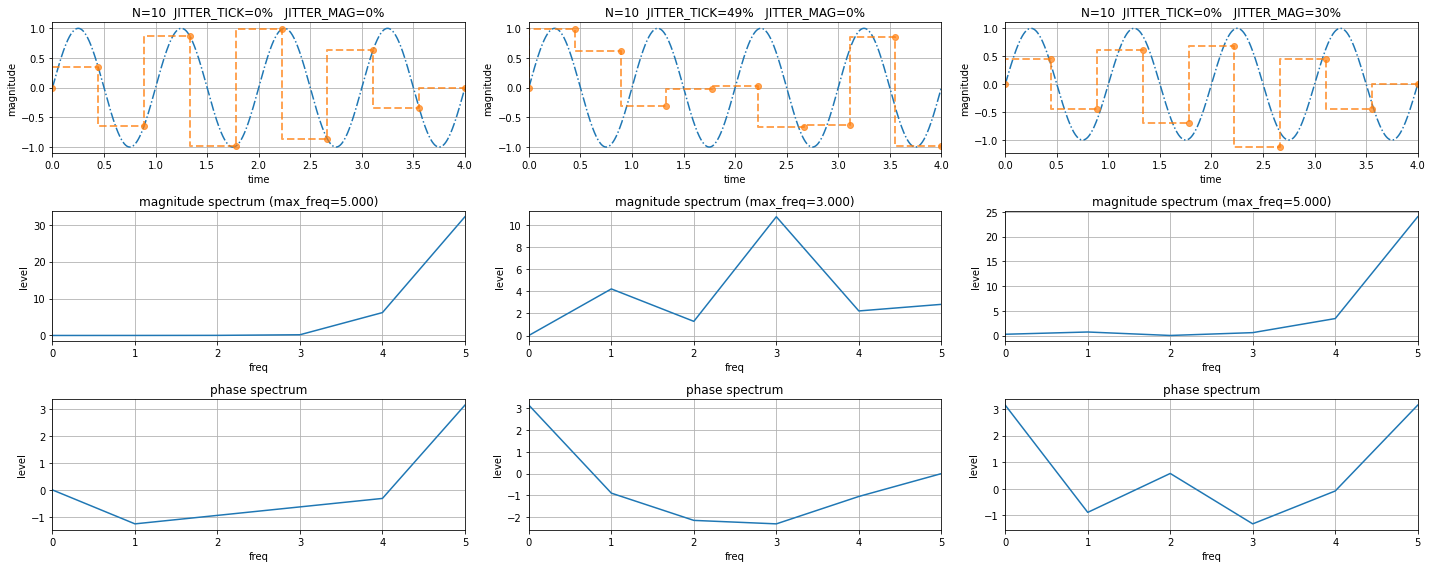

In [16]:
SIN_FREQ = 4

ideal_x, ideal_y = sin_tick(10000, SIN_FREQ)

N_FFT = 2048

for i, (sampling_rate, jit_tick, jit_amp) in enumerate((
    (10000, 49, 30),
    (5000, 49, 30),
    (500, 49, 30),
    (100, 49, 30),
    (25, 49, 30),
    (10, 49, 30),
)):
    fig = plt.figure(figsize=(20, 8))
    variants = (
        (0, 0),
        (jit_tick, 0),
        (0, jit_amp),
#         (jit_tick, jit_amp),
    )
    print(f'\n\nsampling_rate={sampling_rate}')
    for i, (jit_tick, jit_amp) in enumerate(variants):
        plt.subplot(3, len(variants), i + 1)
        plt.plot(ideal_x, ideal_y, '-.')
        plt.xlim((ideal_x[0], ideal_x[-1]))
        plt.grid()
        plt.title(f'N={sampling_rate}  JITTER_TICK={jit_tick}%   JITTER_MAG={jit_amp}%')

        x, y = sin_tick_rand_jitter(sampling_rate, SIN_FREQ, jit_tick, jit_amp)
        plt.step(x, y, '--o', linewidth=2.0, alpha=0.7)
        plt.xlabel("time")
        plt.ylabel("magnitude")

        plt.subplot(3, len(variants), i + 1 + len(variants))
        spectrum_magnitude(y, sampling_rate, plot=True)

        # phase
        plt.subplot(3, len(variants), i + 1 + 2 * len(variants))
        spectrum_phase(y, sampling_rate, plot=True)

    plt.tight_layout()
    plt.show()


# Convolution

In [17]:
T = TypeVar('T')

def convolution(s1: List[T], s2: List[T]) -> List[T]:
    s1, s2 = (s1, s2) if len(s1) > len(s2) else (s2, s1)
    z = [0] * (len(s2) - 1)
    ps = z + list(s1) + z
    s2_i = list(range(len(s2)))
    return [sum(ps[i+j] * s2[-j-1] for j in s2_i) for i in range(len(s1) + len(z))]

In [18]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 20]

[]

[]

In [19]:
%%timeit
c = convolution(a, b)

60.3 µs ± 367 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
np.array(convolution(a, b))

array([  1,   4,  10,  20,  35,  56,  84, 120, 165, 220, 275, 330, 385,
       440, 495, 550, 605, 660, 714, 768, 801, 812, 800, 764, 703, 616,
       502, 360, 200])

# Spectrum

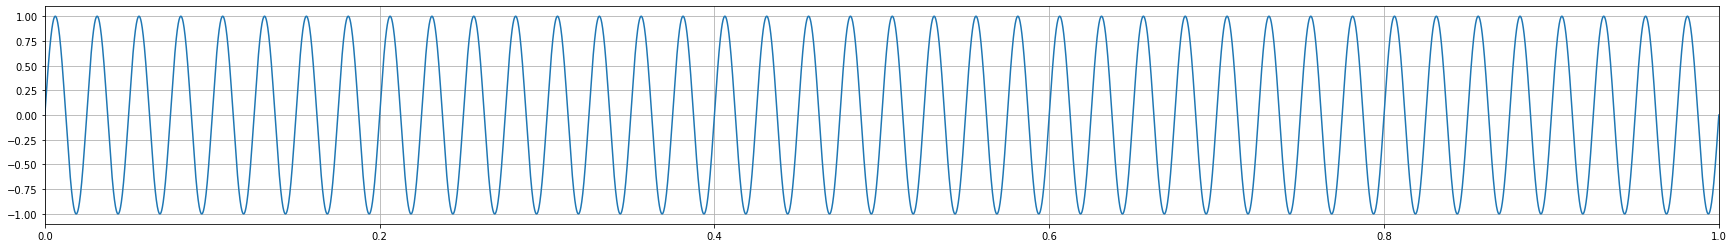

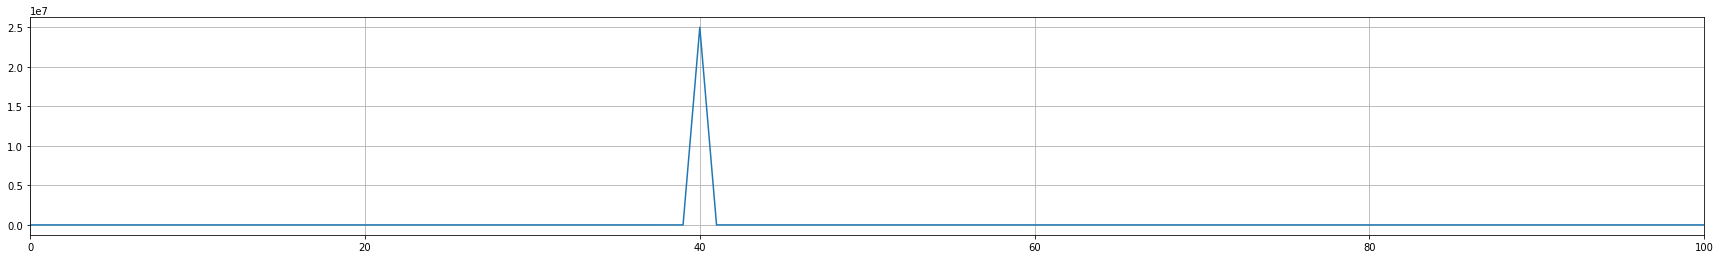

In [21]:
sampling_rate = 10000
t = np.linspace(0, 1, sampling_rate)

carrier_freq = 40

carrier_signal = np.sin(2*np.pi*carrier_freq*t)

signal_fft = np.fft.rfft(carrier_signal, sampling_rate)
spectrum = np.square(np.abs(signal_fft))

freq = np.linspace(0, sampling_rate/2, len(signal_fft))

plt.figure(figsize=(30, 4))
plt.grid()
plt.xlim((0, 1))
plt.plot(t, carrier_signal)
plt.show()

plt.figure(figsize=(30, 4))
plt.plot(freq, spectrum)
plt.xlim((0, 100))
plt.grid()
plt.show()


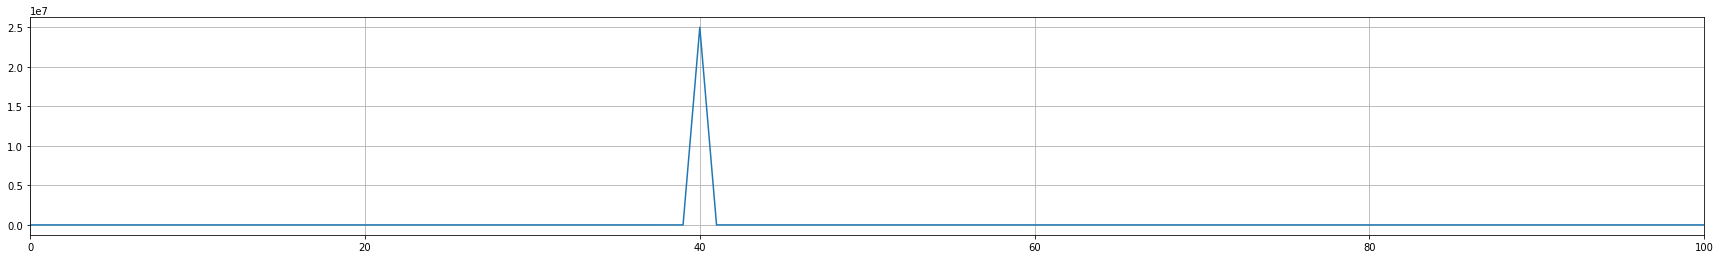

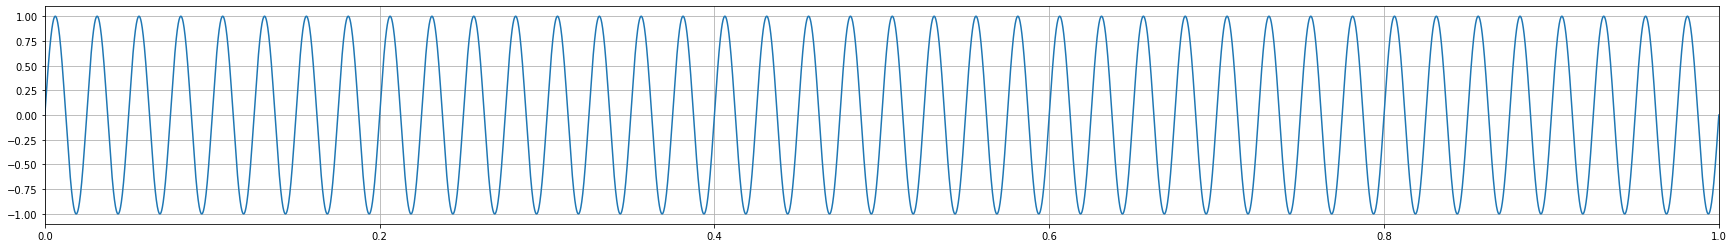

In [22]:
plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(signal_fft)), np.square(np.abs(signal_fft)))
plt.xlim((0, 100))
plt.show()

mk_signal_by_spectrum_magnitude(signal_fft, sampling_rate)

# AM

In [23]:
def simple_sin(t, freq):
    return np.sin(2*np.pi*freq*t)

def simple_signal_plot(t, signal, lim_f = None):
    signal_fft = np.fft.rfft(signal, len(t))
    freq = np.linspace(0, len(t)/2, len(signal_fft))

    plt.figure(figsize=(30, 4))
    plt.grid()
    plt.xlim((0, 1))
    plt.plot(t, signal)
    plt.show()

    plt.figure(figsize=(30, 4))
    plt.plot(freq, np.square(np.abs(signal_fft)))
    plt.xlim((0, lim_f or freq[-1]))
    plt.grid()
    plt.show()


In [24]:
def am(carrier_signal, message_signal):
    return (1+message_signal)*carrier_signal

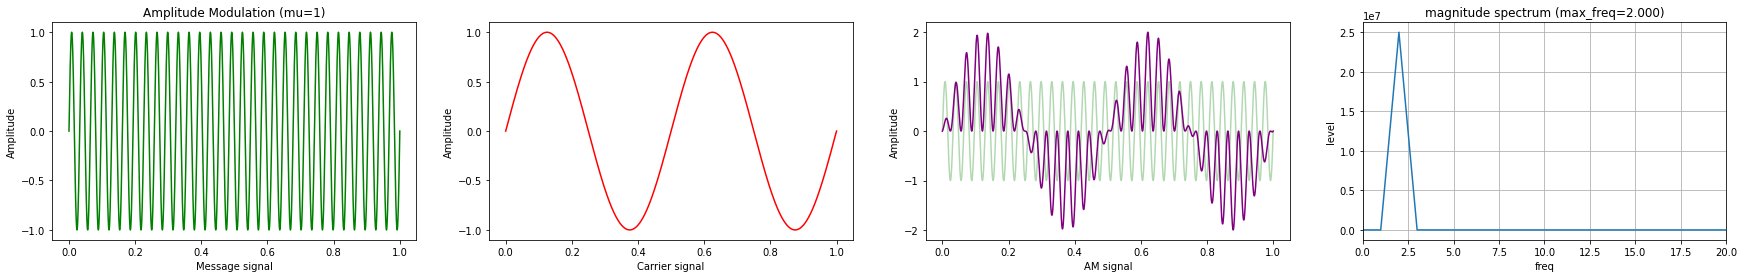

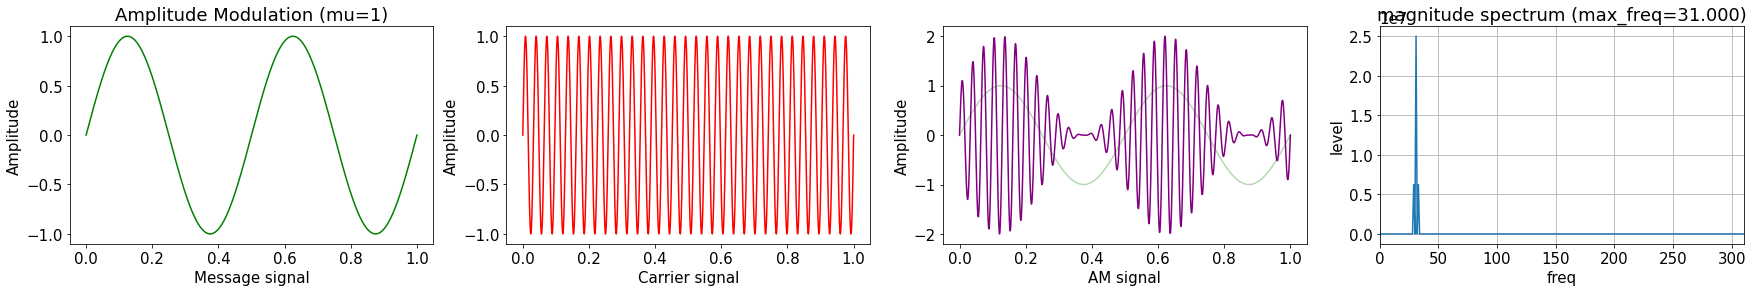

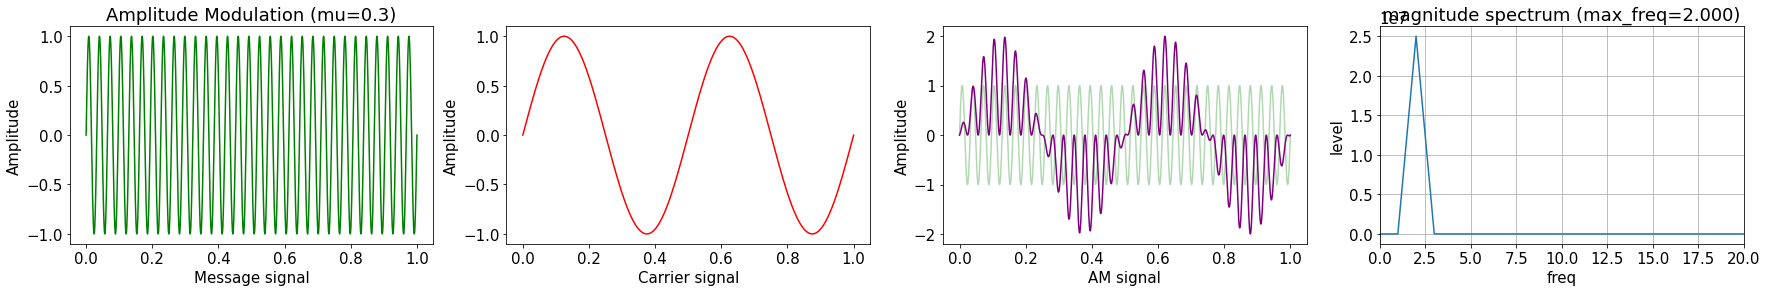

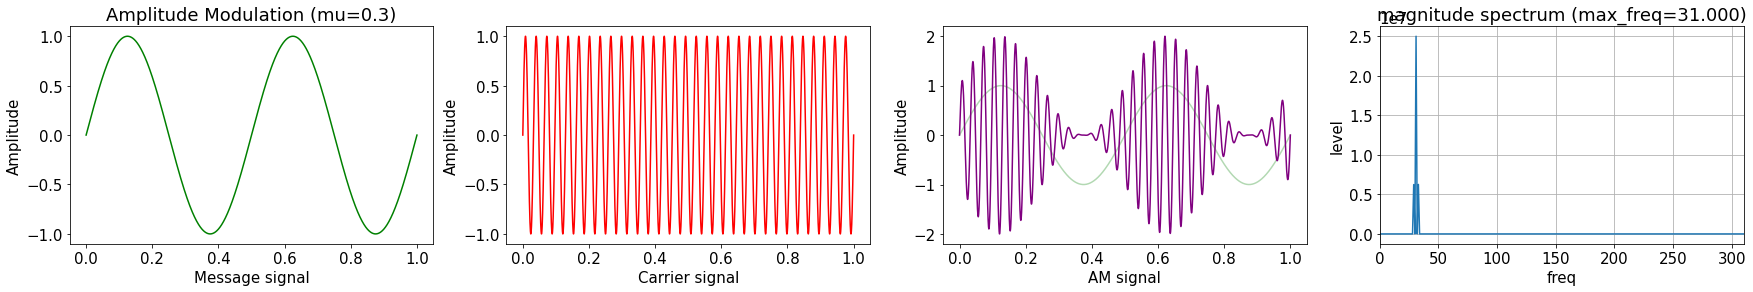

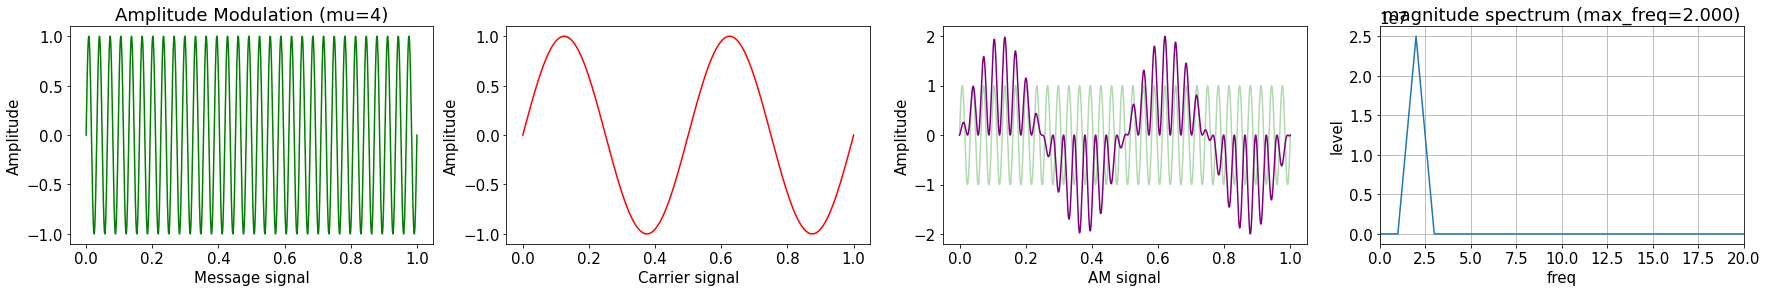

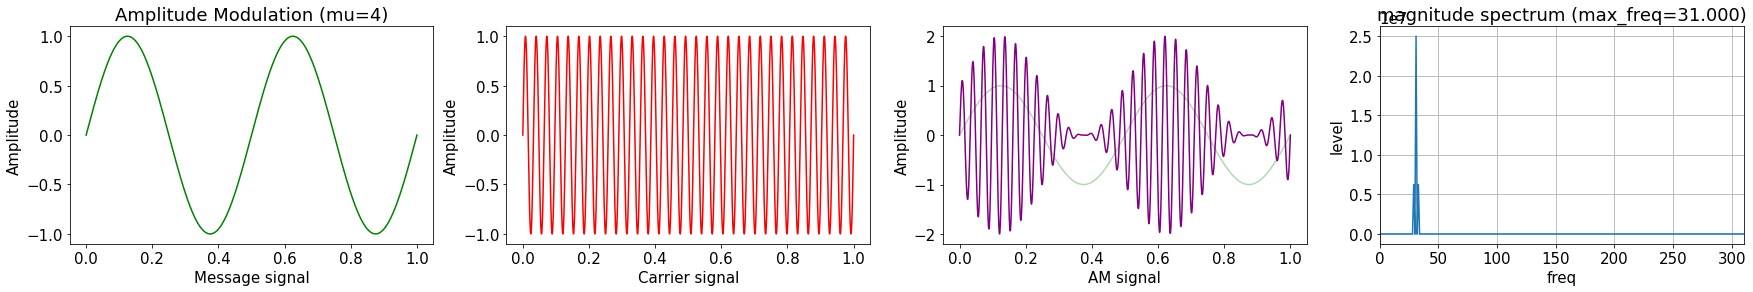

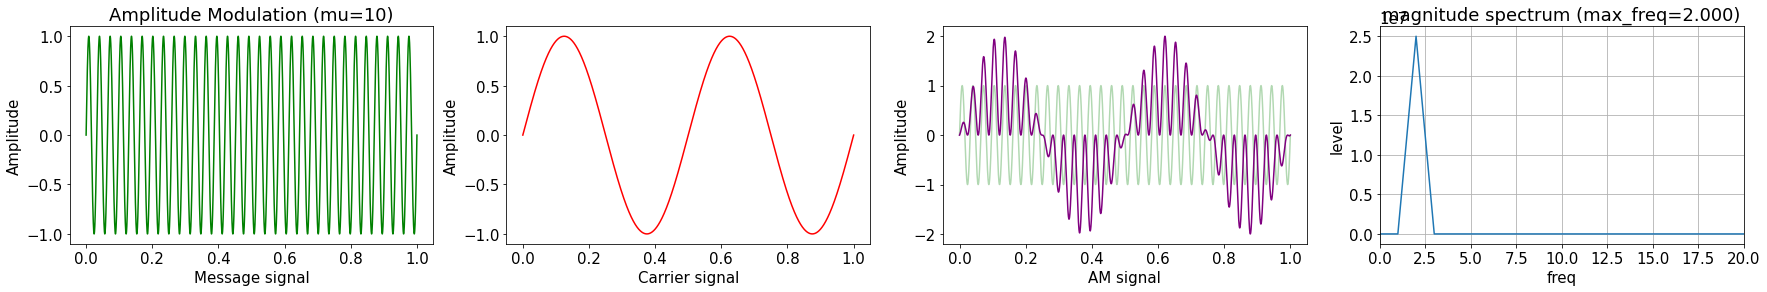

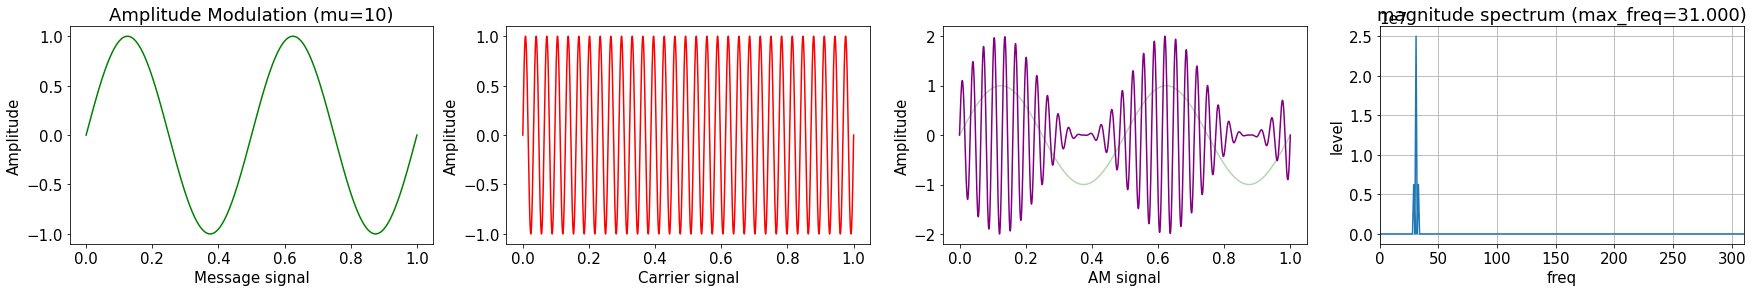

In [25]:
t = np.linspace(0, 1, 10000)
for f_c, f_m, mu in (
    (2, 31, 1),
    (31, 2, 1),
    (2, 31, 0.3),
    (31, 2, 0.3),
    (2, 31, 4),
    (31, 2, 4),
    (2, 31, 10),
    (31, 2, 10),
):
    fig = plt.figure(figsize=(30, 4))

    carrier = simple_sin(t, f_c)
    modulator = simple_sin(t, f_m)
    product = am(carrier, modulator)

    plt.subplot(1,4,1)
    plt.title(f'Amplitude Modulation (mu={mu})')
    plt.plot(t, modulator,'g')
    plt.ylabel('Amplitude')
    plt.xlabel('Message signal')

    plt.subplot(1,4,2)
    plt.plot(t, carrier, 'r')
    plt.ylabel('Amplitude')
    plt.xlabel('Carrier signal')

    plt.subplot(1,4,3)
    plt.plot(t, modulator,'g', alpha=0.3)
    plt.plot(t, product, color="purple")
    plt.ylabel('Amplitude')
    plt.xlabel('AM signal')

    plt.subplot(1, 4, 4)
    spectrum_magnitude(product, len(t), plot=True)

    plt.subplots_adjust(hspace=1)
    plt.rc('font', size=15)
    fig = plt.gcf()
    plt.show()


# AM Spectr|

5
message:


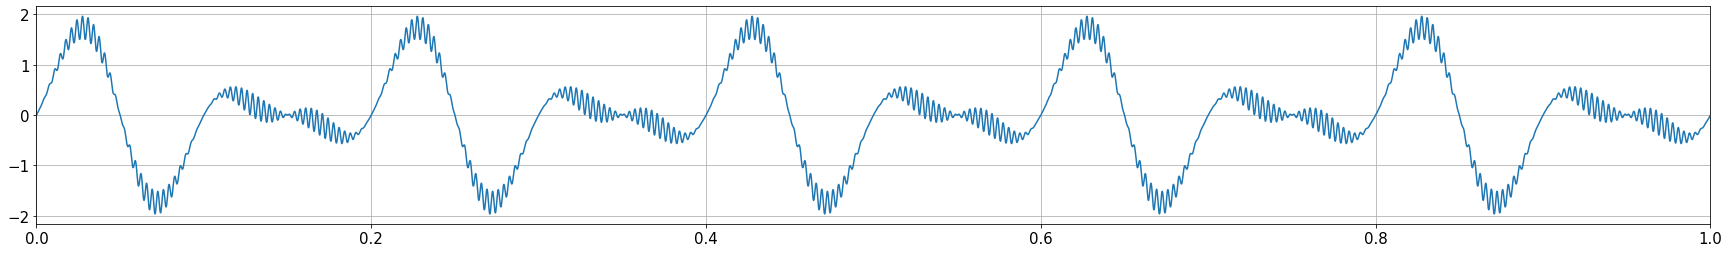

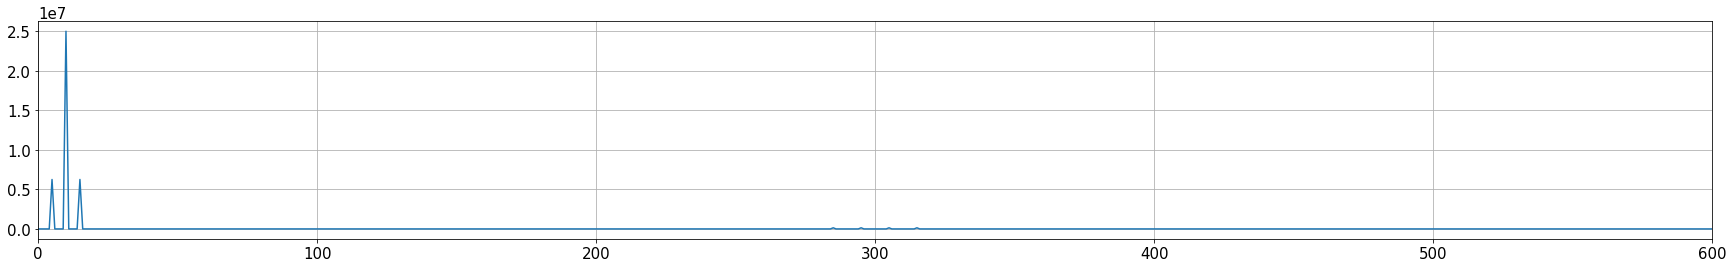

carrier (100):


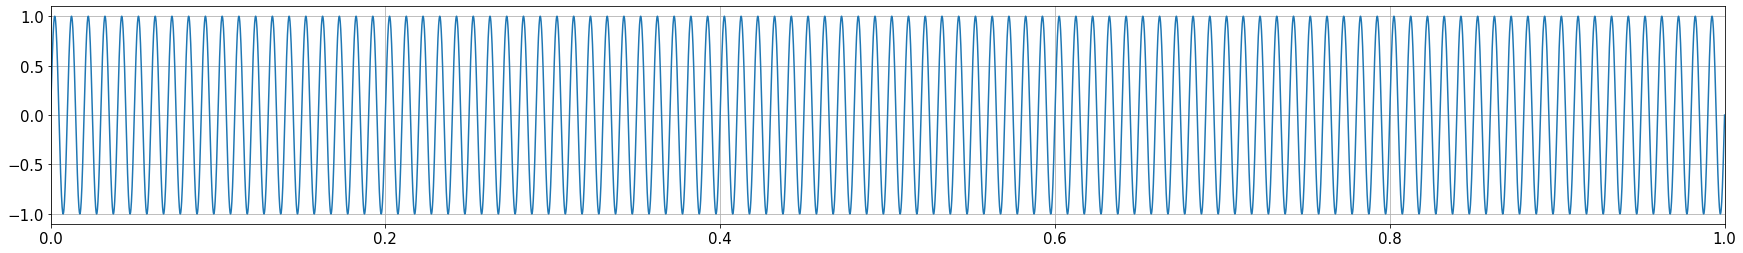

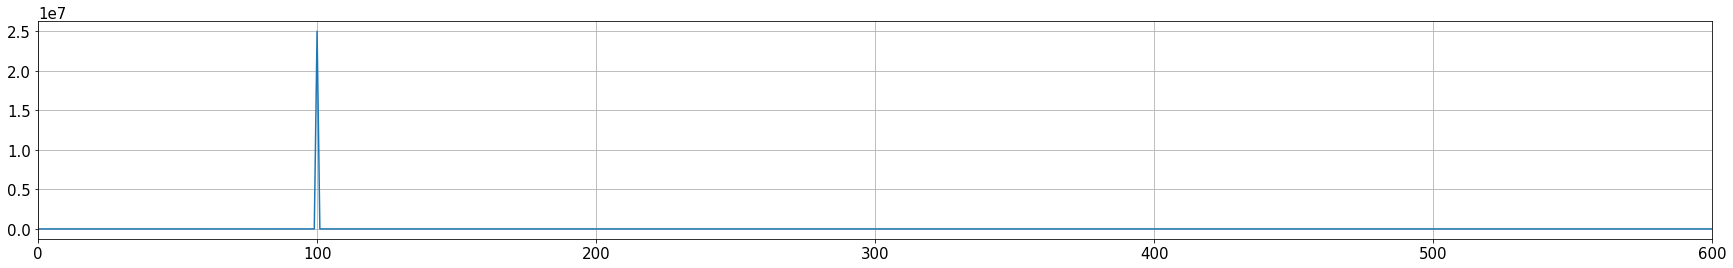

am_signal:


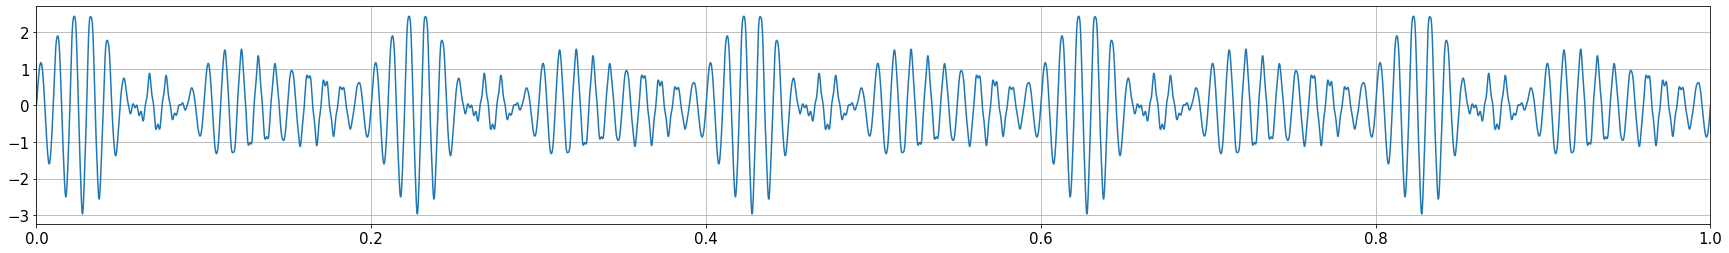

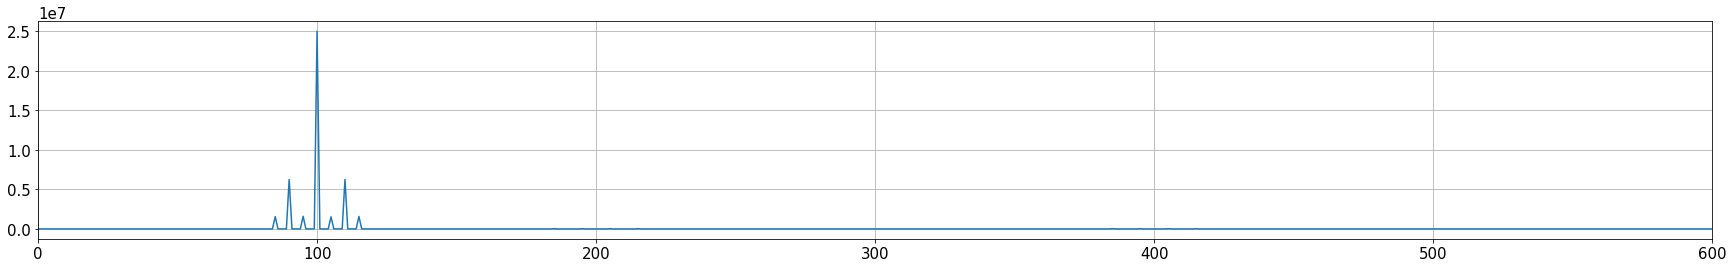

div = am_signal / carrier - 1


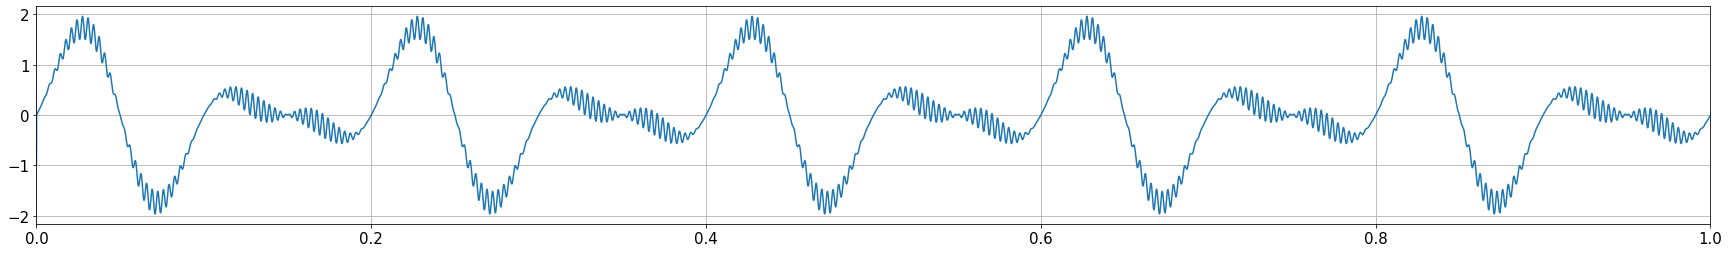

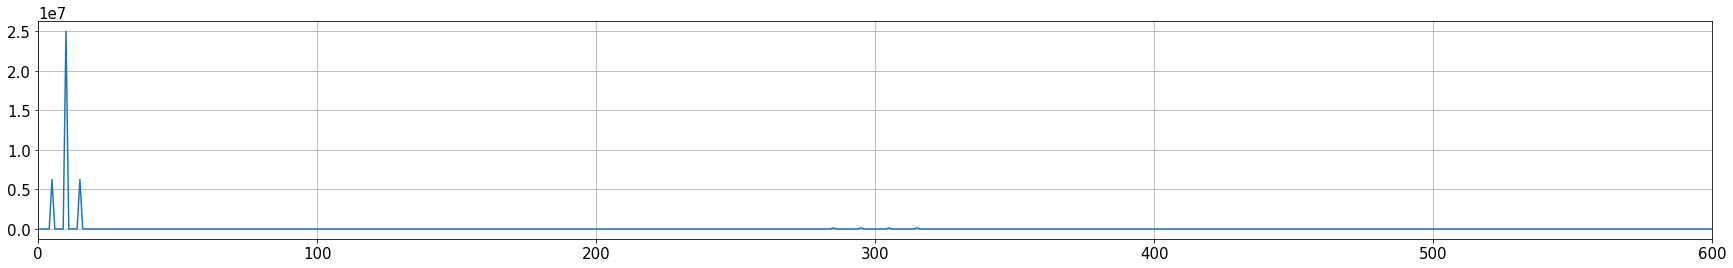

mul = am_signal * carrier


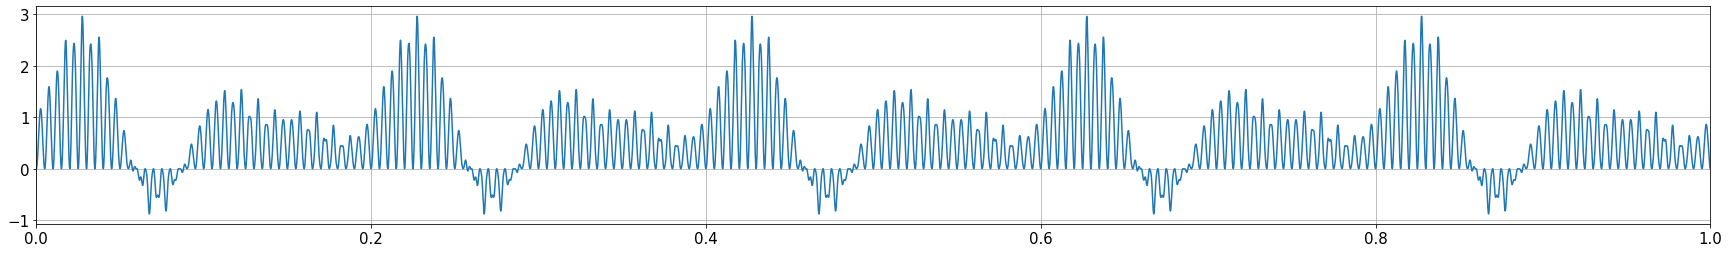

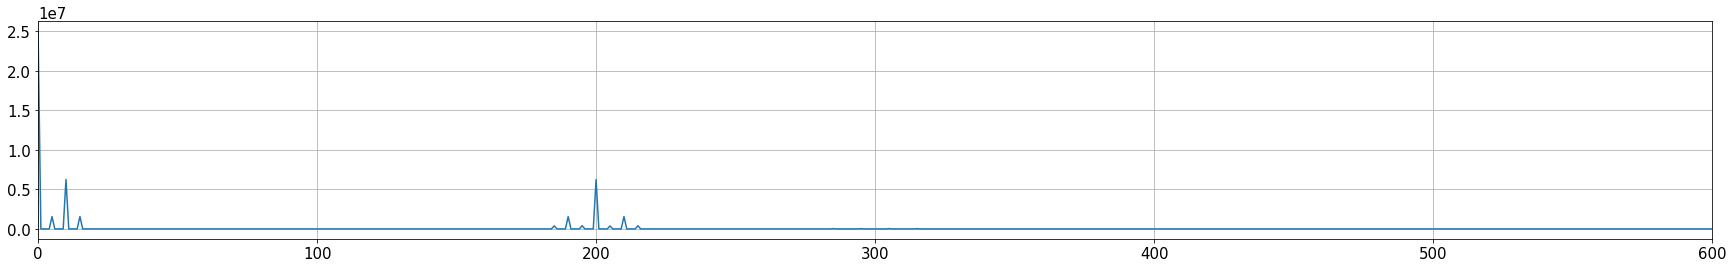

fft_filtered_mul(freq>100=0)


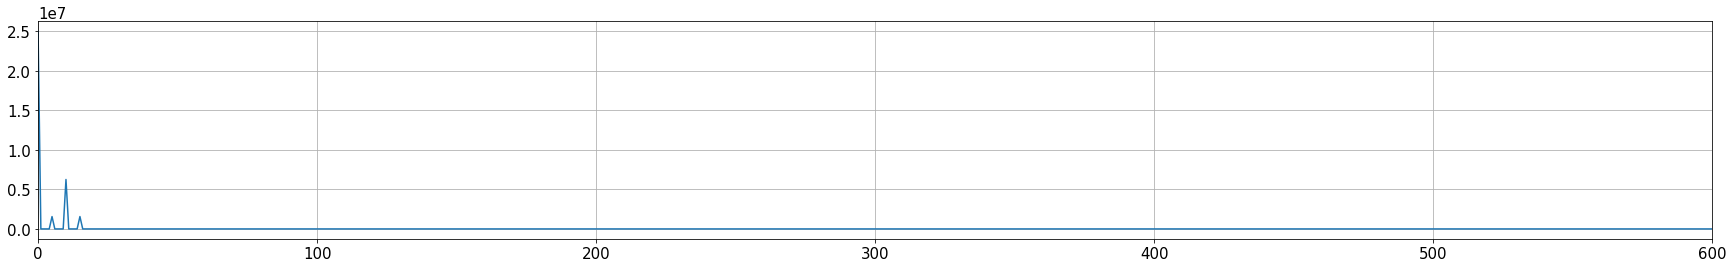

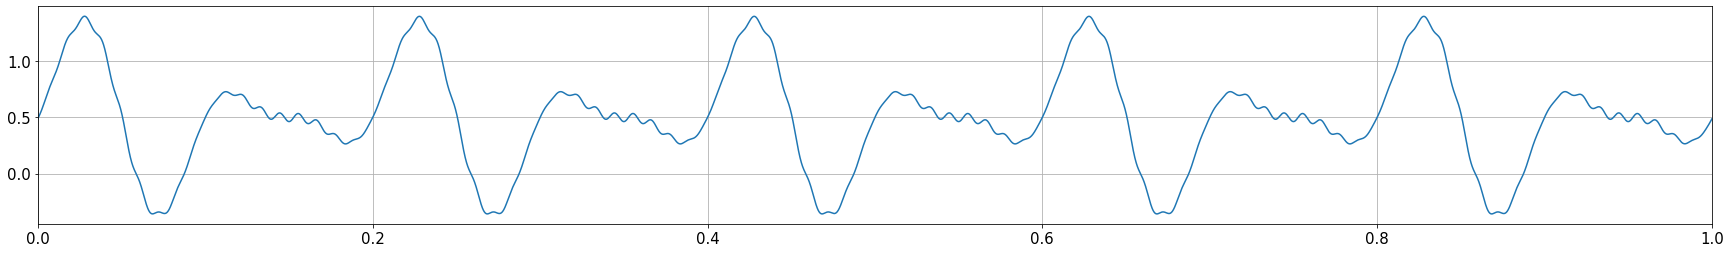

fft_filtered(freq>97 = 0)


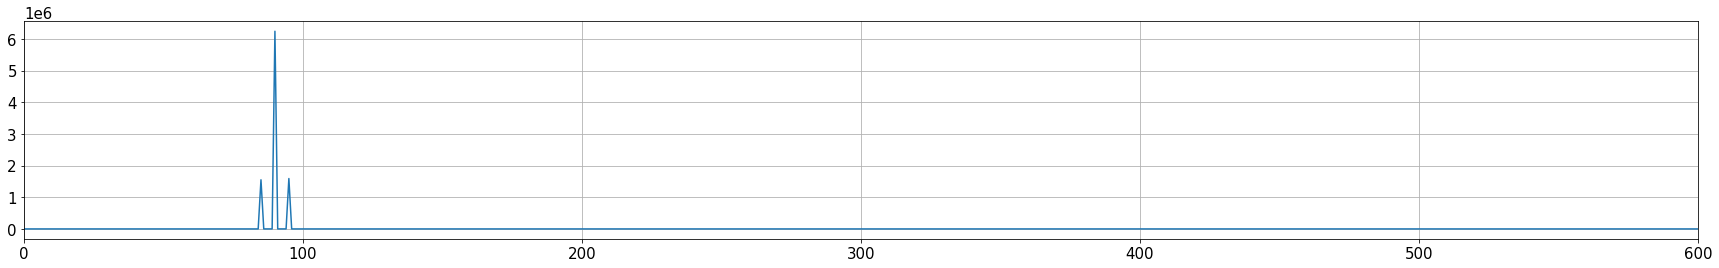

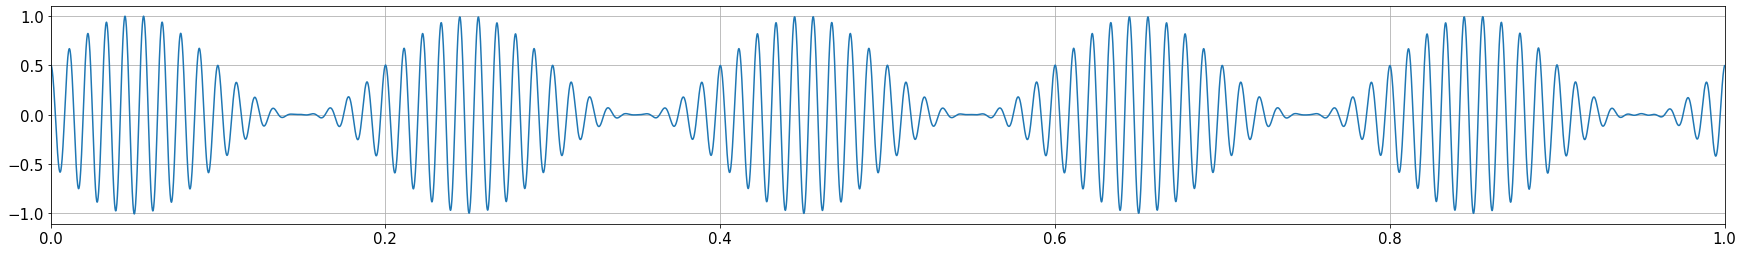

fft_sub = am_signal_fft - carrier_fft


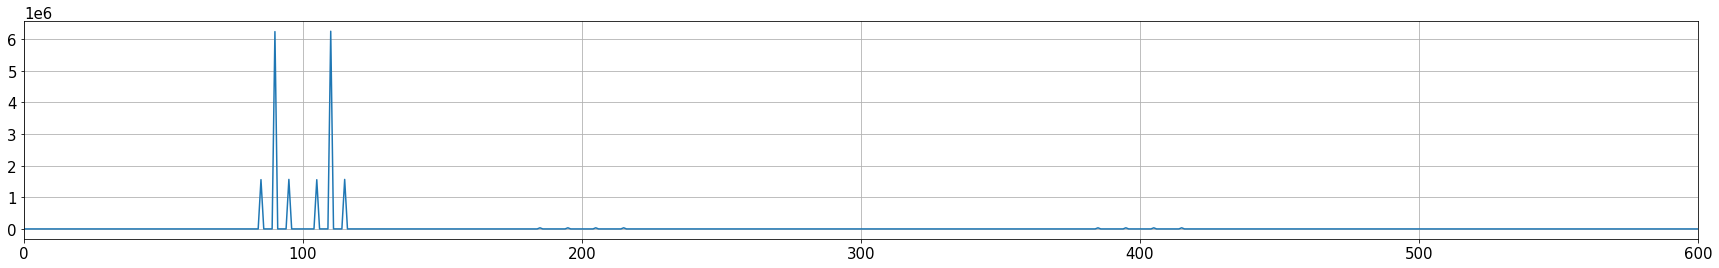

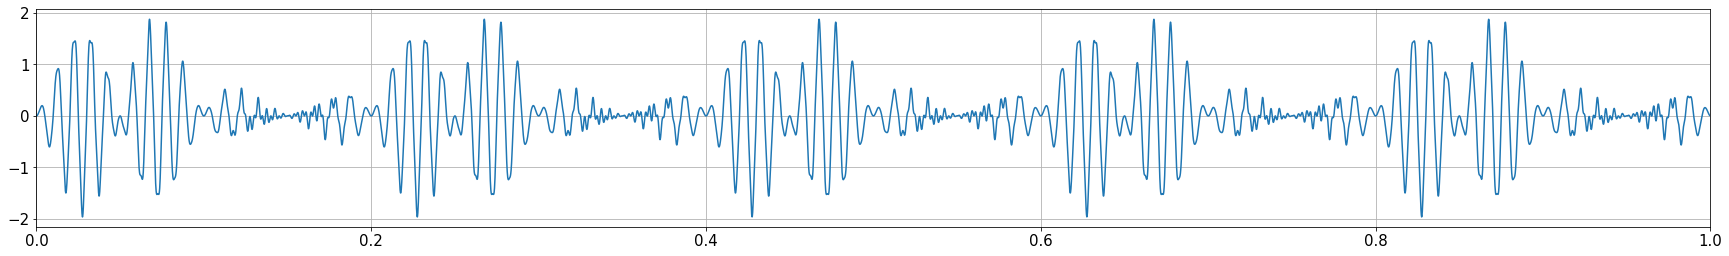

In [27]:
random.seed(123)

sampling_rate = 10000
t = np.linspace(0, 1, sampling_rate)

jit_f = 300
carrier_freq = 100
message_freq = int(100 * random.random())  # unknown
LIMIT_F = max(message_freq, carrier_freq, jit_f) * 2
print(message_freq)

carrier_signal = simple_sin(t, carrier_freq)
message_signal = am(simple_sin(t, message_freq * 2), am(simple_sin(t, message_freq), 0.3 * simple_sin(t, jit_f)))
am_signal = am(carrier_signal, message_signal)

message_signal_fft = np.fft.rfft(message_signal, sampling_rate)
carrier_signal_fft = np.fft.rfft(carrier_signal, sampling_rate)
am_signal_fft = np.fft.rfft(am_signal, sampling_rate)

freq = np.linspace(0, sampling_rate/2, len(am_signal_fft))

print('message:')
simple_signal_plot(t, message_signal, LIMIT_F)

print(f'carrier ({carrier_freq}):')
simple_signal_plot(t, carrier_signal, LIMIT_F)

print('am_signal:')
simple_signal_plot(t, am_signal, LIMIT_F)

print('div = am_signal / carrier - 1')
simple_signal_plot(t, np.divide(am_signal, carrier_signal, out=np.zeros_like(am_signal), where=carrier_signal!=0) - 1, LIMIT_F)

print('mul = am_signal * carrier')
simple_signal_plot(t, am_signal * carrier_signal, LIMIT_F)

print(f'fft_filtered_mul(freq>{carrier_freq}=0)')
r_message_signal_fft = np.fft.rfft(am_signal * carrier_signal, sampling_rate) * (freq < (carrier_freq)).astype(float)
plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(r_message_signal_fft)), np.square(np.abs(r_message_signal_fft)))
plt.xlim((0, LIMIT_F))
plt.show()

mk_signal_by_spectrum_magnitude(r_message_signal_fft, sampling_rate)


FFT_FILTER_TRASHOLD = 3
print(f'fft_filtered(freq>{carrier_freq - FFT_FILTER_TRASHOLD} = 0)')
r_message_signal_fft = am_signal_fft * (freq <= (carrier_freq - FFT_FILTER_TRASHOLD)).astype(float)
plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(r_message_signal_fft)), np.square(np.abs(r_message_signal_fft)))
plt.xlim((0, LIMIT_F))
plt.show()

mk_signal_by_spectrum_magnitude(r_message_signal_fft, sampling_rate)


print('fft_sub = am_signal_fft - carrier_fft')
r_message_signal_fft = am_signal_fft - carrier_signal_fft

plt.figure(figsize=(30, 4))
plt.grid()
plt.plot(np.linspace(0, sampling_rate/2, len(r_message_signal_fft)), np.square(np.abs(r_message_signal_fft)))
plt.xlim((0, LIMIT_F))
plt.show()

mk_signal_by_spectrum_magnitude(r_message_signal_fft, sampling_rate)